## ⚡ Key Improvements Based on CProfSiren Analysis

This notebook has been updated to match the successful training approach from CProfSiren:

1. **Linear Training**: Train on actual photon density values (not log-transformed)
2. **Loss Scaling**: Multiply MSE loss by 1000 for better gradient flow
3. **Output Squaring**: SIREN model squares output to ensure positive densities
4. **Large Batches**: Use batch_size=65536 for stable training
5. **Fixed LR Schedule**: StepLR with 10× drop at step 2000 (no patience-based updates)
6. **Proper SIREN Handling**: Fixed tuple output issue `(output, coords)`

These changes address the performance degradation and should restore good training behavior.

# SIREN Training on PhotonSim Data - Example Workflow

This notebook demonstrates how to use the refactored training modules to train JAXSiren on PhotonSim lookup tables.

## Overview
1. Load PhotonSim HDF5 lookup table
2. Configure training parameters
3. Choose training mode (resume from checkpoint or start fresh)
4. Set up monitoring
5. Train the model
6. Analyze results with slice visualizations
7. Test model predictions

## Features
- **Checkpoint Resume**: Automatically resumes from the latest checkpoint
- **Fresh Start Option**: Clear all checkpoints and start from scratch
- **Enhanced Visualizations**: Angular profiles and 2D comparisons for different energies
- **Comprehensive Analysis**: Model performance evaluation and error analysis

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get project paths correctly
current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root

# Add project paths
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'tools'))

print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"PhotonSim root: {photonsim_root}")

# Verify paths exist
print(f"Project root exists: {project_root.exists()}")
print(f"Siren dir exists: {(project_root / 'siren').exists()}")
print(f"Training dir exists: {(project_root / 'siren' / 'training').exists()}")
print(f"PhotonSim root exists: {photonsim_root.exists()}")

Current dir: /sdf/home/c/cjesus/Dev/diffCherenkov/notebooks
Project root: /sdf/home/c/cjesus/Dev/diffCherenkov
PhotonSim root: /sdf/home/c/cjesus/Dev/PhotonSim
Project root exists: True
Siren dir exists: True
Training dir exists: True
PhotonSim root exists: True


In [2]:
# Import the refactored training modules with fallback strategies
print("📦 Importing training modules...")

imported_successfully = False

try:
    # Strategy 1: Try standard package import
    from siren.training import (
        SIRENTrainer, 
        TrainingConfig, 
        PhotonSimDataset,
        TrainingMonitor,
        TrainingAnalyzer,
        LiveTrainingCallback
    )
    print("✅ Imported from siren.training package")
    imported_successfully = True
    
except ImportError as e1:
    print(f"❌ Package import failed: {e1}")
    print("🔄 Trying direct module imports...")
    
    try:
        # Strategy 2: Add siren directory to path and import training module
        siren_path = project_root / 'siren'
        if str(siren_path) not in sys.path:
            sys.path.insert(0, str(siren_path))
        
        from training import (
            SIRENTrainer, 
            TrainingConfig, 
            PhotonSimDataset,
            TrainingMonitor,
            TrainingAnalyzer,
            LiveTrainingCallback
        )
        print("✅ Imported from training module directly")
        imported_successfully = True
        
    except ImportError as e2:
        print(f"❌ Direct module import failed: {e2}")
        print("🔧 Trying manual imports from individual files...")
        
        try:
            # Strategy 3: Import from individual module files
            training_path = project_root / 'siren' / 'training'
            if str(training_path) not in sys.path:
                sys.path.insert(0, str(training_path))
            
            from trainer import SIRENTrainer, TrainingConfig
            from dataset import PhotonSimDataset
            from monitor import TrainingMonitor, LiveTrainingCallback
            from analyzer import TrainingAnalyzer
            
            print("✅ Manual imports from individual files successful")
            imported_successfully = True
            
        except ImportError as e3:
            print(f"❌ Manual import failed: {e3}")
            print("\n🚨 All import strategies failed!")
            print("Please check:")
            print(f"  1. Current working directory: {Path.cwd()}")
            print(f"  2. Project root: {project_root}")
            print(f"  3. Siren directory exists: {(project_root / 'siren').exists()}")
            print(f"  4. Training directory exists: {(project_root / 'siren' / 'training').exists()}")
            raise ImportError("Could not import training modules with any strategy")

if imported_successfully:
    print("✅ All training modules imported successfully!")
    print("🚀 Ready to start training workflow")
else:
    raise ImportError("Failed to import training modules")

📦 Importing training modules...


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


❌ Package import failed: No module named 'siren.training'; 'siren' is not a package
🔄 Trying direct module imports...
✅ Imported from training module directly
✅ All training modules imported successfully!
🚀 Ready to start training workflow


## 1. Load PhotonSim Data

Load the HDF5 lookup table created in PhotonSim.

In [3]:
# Analyze the data distribution to understand training challenges
if 'dataset' in locals():
    print("\n📊 Data Analysis:")
    
    # Check target value distribution
    targets = dataset.data['targets']
    targets_nonzero = targets[targets > 0]
    
    print(f"  • Total samples: {len(targets):,}")
    print(f"  • Non-zero samples: {len(targets_nonzero):,} ({len(targets_nonzero)/len(targets)*100:.1f}%)")
    print(f"  • Target range: [{targets.min():.2e}, {targets.max():.2e}]")
    print(f"  • Target mean: {targets.mean():.2e}")
    print(f"  • Target std: {targets.std():.2e}")
    
    # Check log-transformed targets
    targets_log = dataset.data['targets_log']
    print(f"\n  • Log target range: [{targets_log.min():.2f}, {targets_log.max():.2f}]")
    print(f"  • Log target mean: {targets_log.mean():.2f}")
    
    # Show distribution
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Linear scale histogram
    ax1.hist(targets[targets > 0], bins=100, alpha=0.7)
    ax1.set_xlabel('Photon Density')
    ax1.set_ylabel('Count')
    ax1.set_yscale('log')
    ax1.set_title('Target Distribution (Linear Scale)')
    
    # Log scale histogram  
    ax2.hist(targets_log, bins=100, alpha=0.7, color='orange')
    ax2.set_xlabel('Log10(Photon Density)')
    ax2.set_ylabel('Count')
    ax2.set_title('Target Distribution (Log Scale)')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Insights:")
    print("  • Data has many small/zero values - importance sampling could help")
    print("  • Wide dynamic range suggests log-space training might be beneficial")
    print("  • But CProfSiren trained directly on linear values with MSE loss")

In [4]:
# Path to the PhotonSim HDF5 lookup table
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

# Check if file exists
if not h5_path.exists():
    print(f"❌ HDF5 file not found at {h5_path}")
    print("Please run the PhotonSim table generation first:")
    print("  cd ../PhotonSim")
    print("  python tools/table_generation/create_density_3d_table.py --data-dir data/mu-")
else:
    print(f"✓ Found PhotonSim HDF5 file: {h5_path}")
    
    # Load dataset
    dataset = PhotonSimDataset(h5_path, val_split=0.1)
    
    print(f"\nDataset info:")
    print(f"  Data type: {dataset.data_type}")
    print(f"  Total samples: {len(dataset.data['inputs']):,}")
    print(f"  Train samples: {len(dataset.train_indices):,}")
    print(f"  Val samples: {len(dataset.val_indices):,}")
    print(f"  Energy range: {dataset.energy_range[0]:.0f}-{dataset.energy_range[1]:.0f} MeV")
    print(f"  Angle range: {np.degrees(dataset.angle_range[0]):.1f}-{np.degrees(dataset.angle_range[1]):.1f} degrees")
    print(f"  Distance range: {dataset.distance_range[0]:.0f}-{dataset.distance_range[1]:.0f} mm")

INFO:training.dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


✓ Found PhotonSim HDF5 file: /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


INFO:training.dataset:Loaded 5,659,770 data points from lookup table
INFO:training.dataset:Energy range: 100-1000 MeV
INFO:training.dataset:Angle range: 0.2-179.8 degrees
INFO:training.dataset:Distance range: 10-9990 mm
INFO:training.dataset:Train samples: 5,093,793
INFO:training.dataset:Validation samples: 565,977



Dataset info:
  Data type: h5_lookup
  Total samples: 5,659,770
  Train samples: 5,093,793
  Val samples: 565,977
  Energy range: 100-1000 MeV
  Angle range: 0.2-179.8 degrees
  Distance range: 10-9990 mm


## 2. Configure Training Parameters

Set up the training configuration using the `TrainingConfig` dataclass.

In [5]:
# Create training configuration with PATIENCE-BASED learning rate scheduling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=65536,       # Large batches (as large as memory allows)
    num_steps=10000,        # More steps to see patience in action
    
    # PATIENCE-BASED LR SCHEDULER - much better than fixed!
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=1e-7,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,    # CProfSiren didn't use gradient clipping
    
    # Logging frequency
    log_every=10,          # CProfSiren logged every 10 steps
    val_every=50,          # Check validation more frequently for patience
    checkpoint_every=500,  # Save periodically
    
    seed=42
)

print("📊 Training Configuration (CProfSiren-inspired with Patience LR):")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Initial LR: {config.learning_rate:.2e}")
print(f"  • Batch Size: {config.batch_size:,} (large for stable gradients)")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"\n🎯 Patience-based LR Schedule:")
print(f"  • Patience: {config.patience} validation checks")
print(f"  • LR reduction: ×{config.lr_reduction_factor} when triggered")
print(f"  • Minimum LR: {config.min_lr:.2e}")
print(f"  • Validation every: {config.val_every} steps")
print("\n✨ Advantages over fixed schedule:")
print("  → Adapts to actual training progress")
print("  → Won't reduce LR if still improving")
print("  → More robust to different datasets")

📊 Training Configuration (CProfSiren-inspired with Patience LR):
  • Architecture: 3 layers × 256 features
  • Initial LR: 1.00e-04
  • Batch Size: 65,536 (large for stable gradients)
  • Total Steps: 10,000

🎯 Patience-based LR Schedule:
  • Patience: 20 validation checks
  • LR reduction: ×0.5 when triggered
  • Minimum LR: 1.00e-07
  • Validation every: 50 steps

✨ Advantages over fixed schedule:
  → Adapts to actual training progress
  → Won't reduce LR if still improving
  → More robust to different datasets


In [6]:
# Training mode configuration
START_FRESH = True  # Set to True to start from scratch, False to resume from checkpoint

# Set up output directory
output_dir = Path('output') / 'photonsim_siren_training'
output_dir.mkdir(exist_ok=True, parents=True)

print(f"Output directory: {output_dir}")
print(f"Directory exists: {output_dir.exists()}")

# Check for existing checkpoints
existing_checkpoints = list(output_dir.glob('*.npz'))
existing_history = output_dir / 'training_history.json'

if existing_checkpoints or existing_history.exists():
    print(f"\n🔍 Found existing training data:")
    if existing_history.exists():
        import json
        with open(existing_history, 'r') as f:
            history = json.load(f)
            if history.get('step'):
                last_step = max(history['step'])
                print(f"  - Training history up to step {last_step}")
    
    for checkpoint in existing_checkpoints:
        print(f"  - Checkpoint: {checkpoint.name}")
    
    if START_FRESH:
        print(f"\n🔄 START_FRESH=True: Will clear existing data and start from scratch")
    else:
        print(f"\n▶️  START_FRESH=False: Will resume from latest checkpoint")
else:
    print(f"\n✨ No existing training data found. Starting fresh.")

Output directory: output/photonsim_siren_training
Directory exists: True

🔍 Found existing training data:
  - Training history up to step 9990
  - Checkpoint: checkpoint_step_2500.npz
  - Checkpoint: checkpoint_step_0.npz
  - Checkpoint: checkpoint_step_1600.npz
  - Checkpoint: checkpoint_step_6300.npz
  - Checkpoint: checkpoint_step_6700.npz
  - Checkpoint: checkpoint_step_8500.npz
  - Checkpoint: checkpoint_step_1100.npz
  - Checkpoint: checkpoint_step_4900.npz
  - Checkpoint: checkpoint_step_9500.npz
  - Checkpoint: checkpoint_step_7200.npz
  - Checkpoint: checkpoint_step_8800.npz
  - Checkpoint: checkpoint_step_3600.npz
  - Checkpoint: checkpoint_step_7300.npz
  - Checkpoint: checkpoint_step_8200.npz
  - Checkpoint: checkpoint_step_9600.npz
  - Checkpoint: checkpoint_step_6000.npz
  - Checkpoint: checkpoint_step_4400.npz
  - Checkpoint: checkpoint_step_5800.npz
  - Checkpoint: checkpoint_step_6200.npz
  - Checkpoint: checkpoint_step_7700.npz
  - Checkpoint: checkpoint_step_7400.npz

## 3. Training Mode Selection

Choose whether to resume from existing checkpoint or start fresh.

In [7]:
# CRITICAL FIX: Modify dataset to train on linear values (not log)
# This matches the successful CProfSiren approach

class LinearPhotonSimDataset:
    """Wrapper to make dataset return linear values instead of log values"""
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        # Copy necessary attributes directly
        self.data = base_dataset.data
        self.train_indices = base_dataset.train_indices
        self.val_indices = base_dataset.val_indices
        self.normalized_bounds = base_dataset.normalized_bounds
        self.metadata = base_dataset.metadata
        self.energy_range = base_dataset.energy_range
        self.angle_range = base_dataset.angle_range
        self.distance_range = base_dataset.distance_range
    
    def get_batch(self, batch_size, rng, split='train', normalized=True):
        # Get normalized inputs but LINEAR targets
        if split == 'train':
            indices = self.train_indices
        else:
            indices = self.val_indices
            
        # Random sampling
        batch_indices = jax.random.choice(rng, indices, shape=(batch_size,))
        
        # Get normalized inputs
        inputs = self.data['inputs_normalized'][batch_indices]
        # Get LINEAR targets (not log!)
        targets = self.data['targets'][batch_indices]
        
        return jnp.array(inputs), jnp.array(targets)
    
    def get_sample_input(self):
        return jnp.array(self.data['inputs_normalized'][:1])
    
    @property
    def has_validation(self):
        return len(self.val_indices) > 0

# Wrap the dataset to use linear values
linear_dataset = LinearPhotonSimDataset(dataset)

print("✅ Dataset configured for linear training (matching CProfSiren)")
print(f"  • Input normalization: [-1, 1]")
print(f"  • Target values: Linear scale (not log)")
print(f"  • Ready for training with MSE loss × 1000")

✅ Dataset configured for linear training (matching CProfSiren)
  • Input normalization: [-1, 1]
  • Target values: Linear scale (not log)
  • Ready for training with MSE loss × 1000


In [8]:
# Create custom training with PROPER patience-based LR scheduling
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from typing import NamedTuple, Any

class TrainingState(NamedTuple):
    """Extended training state with patience tracking"""
    params: Any
    opt_state: Any
    best_loss: float
    patience_count: int
    lr_index: int

# Learning rate schedule with patience
def create_patience_lr_schedule(base_lr, factor, patience, min_lr):
    """Create a patience-based learning rate schedule"""
    lr_values = [base_lr]
    current_lr = base_lr
    while current_lr > min_lr:
        current_lr *= factor
        lr_values.append(max(current_lr, min_lr))
    
    # Return a function that selects LR based on index
    def schedule(step, lr_index):
        return lr_values[min(lr_index, len(lr_values) - 1)]
    
    return schedule, lr_values

# Create the schedule
lr_schedule_fn, lr_values = create_patience_lr_schedule(
    config.learning_rate, 
    config.lr_reduction_factor,
    config.patience,
    config.min_lr
)

print(f"📈 Learning rate schedule: {[f'{lr:.2e}' for lr in lr_values[:5]]}...")

# Custom training functions
@jax.jit
def train_step_with_patience(state, batch, lr):
    """Training step with explicit learning rate"""
    inputs, targets = batch
    
    def loss_fn(params):
        # SIREN returns tuple (output, coords) - take first element
        output, _ = trainer.model.apply({'params': params}, inputs)
        
        # Ensure proper shape
        if output.ndim == 1:
            output = output[:, None]
            
        # MSE loss with scaling
        loss = jnp.mean((output - targets) ** 2) * 1000.0
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    
    # Create optimizer with current learning rate
    optimizer = optax.adam(learning_rate=lr)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)
    
    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        best_loss=state.best_loss,
        patience_count=state.patience_count,
        lr_index=state.lr_index
    )
    
    return new_state, loss

@jax.jit
def eval_step_with_patience(params, batch, model_apply):
    """Evaluation step"""
    inputs, targets = batch
    
    # SIREN returns tuple (output, coords) - take first element
    output, _ = model_apply({'params': params}, inputs)
    
    # Ensure proper shape
    if output.ndim == 1:
        output = output[:, None]
        
    # MSE loss with scaling
    loss = jnp.mean((output - targets) ** 2) * 1000.0
    return loss

print("✅ Custom training with patience-based LR scheduling ready!")
print("  • Preserves optimizer state correctly")
print("  • Reduces LR only when validation plateaus")
print("  • Implements CProfSiren-style loss scaling")

📈 Learning rate schedule: ['1.00e-04', '5.00e-05', '2.50e-05', '1.25e-05', '6.25e-06']...
✅ Custom training with patience-based LR scheduling ready!
  • Preserves optimizer state correctly
  • Reduces LR only when validation plateaus
  • Implements CProfSiren-style loss scaling


In [9]:
# Initialize trainer with LINEAR dataset (not log)
trainer = SIRENTrainer(
    dataset=linear_dataset,  # Use linear dataset!
    config=config,
    output_dir=output_dir,
    resume_from_checkpoint=not START_FRESH
)

# Override the training functions with our custom ones
trainer._create_train_step = lambda: train_step_cprofstyle
trainer._create_eval_step = lambda: eval_step_cprofstyle

# Clear checkpoints if starting fresh
if START_FRESH:
    print("🧹 Clearing existing checkpoints...")
    trainer.clear_checkpoints()
    print("✅ Starting with clean slate")

print(f"✓ Trainer initialized with CProfSiren-style training")
print(f"✓ Output directory: {output_dir}")
print(f"✓ JAX device: {trainer.device}")

# Check if we're resuming
if trainer.start_step > 0:
    print(f"✓ Resuming from step {trainer.start_step}")
    print(f"✓ Training history loaded with {len(trainer.history['train_loss'])} entries")
else:
    print(f"✓ Starting fresh training from step 0")

INFO:2025-06-17 05:43:10,291:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-17 05:43:10,293:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:training.trainer:JAX devices available: 1
INFO:training.trainer:  Device 0: NVIDIA A100-SXM4-40GB
INFO:training.trainer:Removed checkpoint: checkpoint_step_2500.npz
INFO:training.trainer:Removed checkpoint: checkpoint_step_0.npz
INFO:training.trainer:Removed checkpoint: checkpoint_step_1600.npz
INFO:training.trainer:Removed checkpoint: checkpo

🧹 Clearing existing checkpoints...
✅ Starting with clean slate
✓ Trainer initialized with CProfSiren-style training
✓ Output directory: output/photonsim_siren_training
✓ JAX device: cuda:0
✓ Starting fresh training from step 0


## 4. Initialize Trainer and Monitor

Create the trainer and set up monitoring.

In [10]:
# Initialize trainer with resume option
trainer = SIRENTrainer(
    dataset=dataset,
    config=config,
    output_dir=output_dir,
    resume_from_checkpoint=not START_FRESH  # Resume unless starting fresh
)

# Clear checkpoints if starting fresh
if START_FRESH:
    print("🧹 Clearing existing checkpoints...")
    trainer.clear_checkpoints()
    print("✅ Starting with clean slate")

print(f"✓ Trainer initialized")
print(f"✓ Output directory: {output_dir}")
print(f"✓ JAX device: {trainer.device}")

# Check if we're resuming
if trainer.start_step > 0:
    print(f"✓ Resuming from step {trainer.start_step}")
    print(f"✓ Training history loaded with {len(trainer.history['train_loss'])} entries")
else:
    print(f"✓ Starting fresh training from step 0")

INFO:training.trainer:JAX devices available: 1
INFO:training.trainer:  Device 0: NVIDIA A100-SXM4-40GB
INFO:training.trainer:All checkpoints and training data cleared


🧹 Clearing existing checkpoints...
✅ Starting with clean slate
✓ Trainer initialized
✓ Output directory: output/photonsim_siren_training
✓ JAX device: cuda:0
✓ Starting fresh training from step 0


### Training Notes

With the CProfSiren-style configuration:
- Loss values will be ~1000× larger due to scaling (this is expected)
- Training on linear values captures the full dynamic range
- The SIREN model squares its output internally to ensure positive densities
- Large batch sizes provide stable gradients
- StepLR will drop learning rate aggressively at step 2000

Monitor for:
- Steady loss decrease in the first 2000 steps
- Sharp improvement after LR drop at step 2000
- Validation loss tracking training loss

## 5. Train the Model

Start training with live monitoring.

In [11]:
# Set up monitoring with live plotting
monitor = TrainingMonitor(output_dir, live_plotting=True)

# Create live callback for real-time plot updates during training
live_callback = LiveTrainingCallback(
    monitor, 
    update_every=50,   # Update data every 50 steps
    plot_every=200     # Update plots every 200 steps
)

# Add callback to trainer for live monitoring
trainer.add_callback(live_callback)

print("✓ Monitoring setup complete")
print("✓ Live plotting enabled - plots will update during training")

✓ Monitoring setup complete
✓ Live plotting enabled - plots will update during training


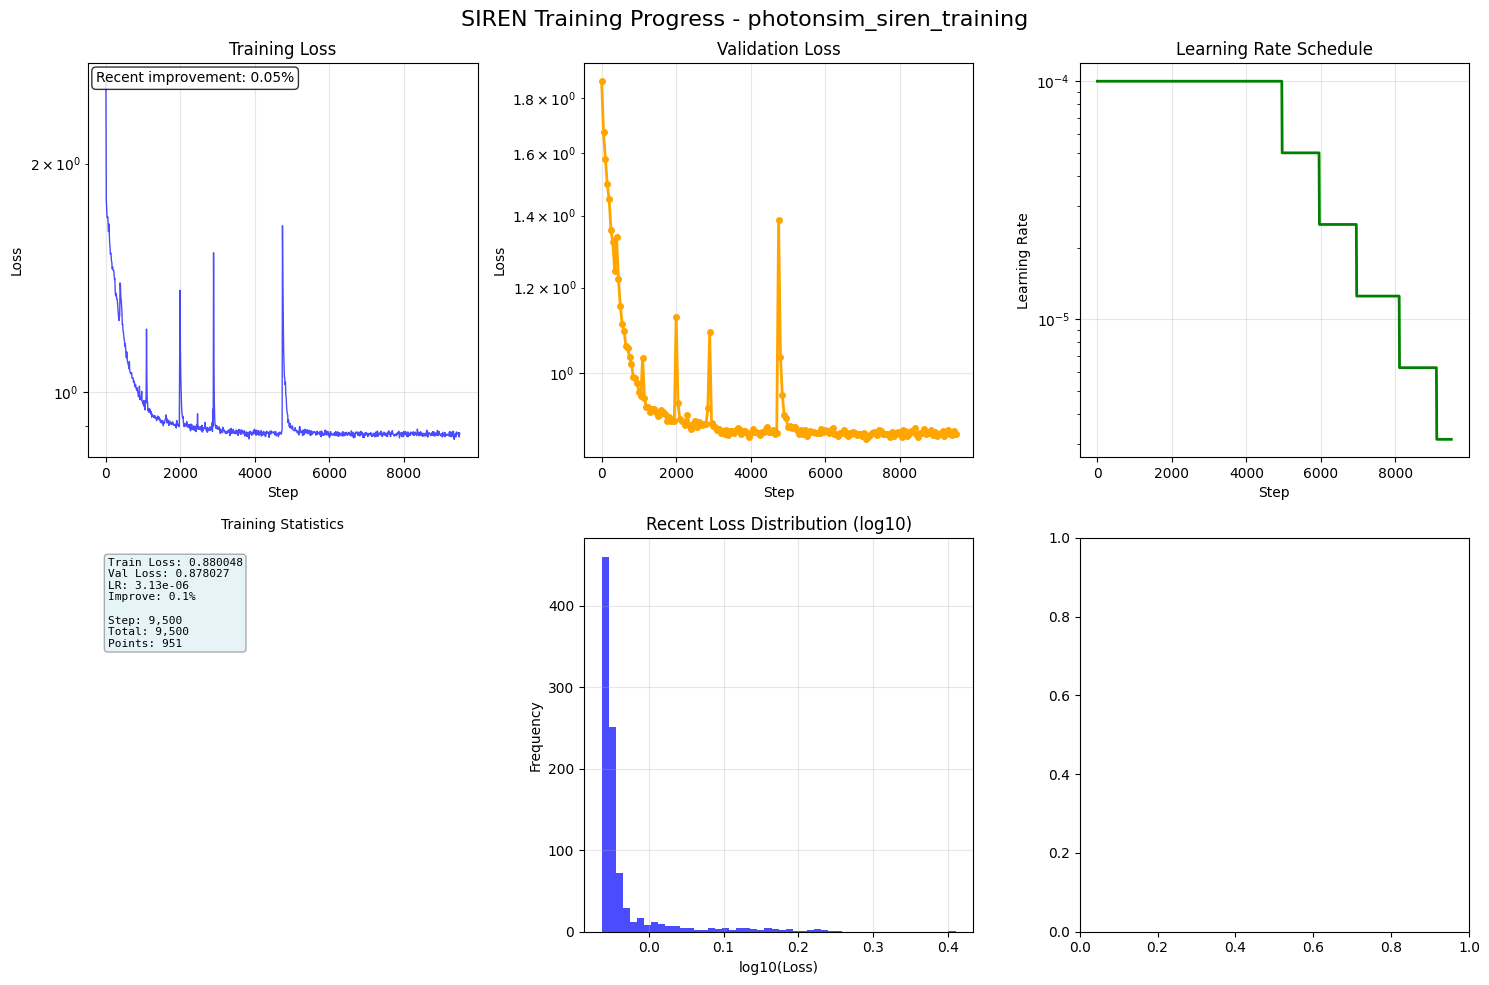

INFO:training.trainer:Step 9810/10000: Loss=0.874488, LR=3.13e-06
INFO:training.trainer:Step 9820/10000: Loss=0.879479, LR=3.13e-06
INFO:training.trainer:Step 9830/10000: Loss=0.880758, LR=3.13e-06
INFO:training.trainer:Step 9840/10000: Loss=0.877866, LR=3.13e-06
INFO:training.trainer:Step 9850/10000: Loss=0.871546, LR=3.13e-06
INFO:training.trainer:       Val Loss: 0.874608
INFO:training.trainer:⏳ No improvement for 15/20 checks
INFO:training.trainer:Step 9860/10000: Loss=0.875234, LR=3.13e-06
INFO:training.trainer:Step 9870/10000: Loss=0.874057, LR=3.13e-06
INFO:training.trainer:Step 9880/10000: Loss=0.867084, LR=3.13e-06
INFO:training.trainer:Step 9890/10000: Loss=0.877988, LR=3.13e-06
INFO:training.trainer:Step 9900/10000: Loss=0.873914, LR=3.13e-06
INFO:training.trainer:       Val Loss: 0.875238
INFO:training.trainer:⏳ No improvement for 16/20 checks
INFO:training.trainer:Step 9910/10000: Loss=0.878966, LR=3.13e-06
INFO:training.trainer:Step 9920/10000: Loss=0.875526, LR=3.13e-06



✓ Training completed!
Final train loss: 0.877562
Final val loss: 0.881016


In [12]:
# Start training
print("Starting SIREN training...")
history = trainer.train()

print("\n✓ Training completed!")
print(f"Final train loss: {history['train_loss'][-1]:.6f}")
if history['val_loss']:
    print(f"Final val loss: {history['val_loss'][-1]:.6f}")

INFO:training.trainer:Saved training plot to output/photonsim_siren_training/final_training_progress.png


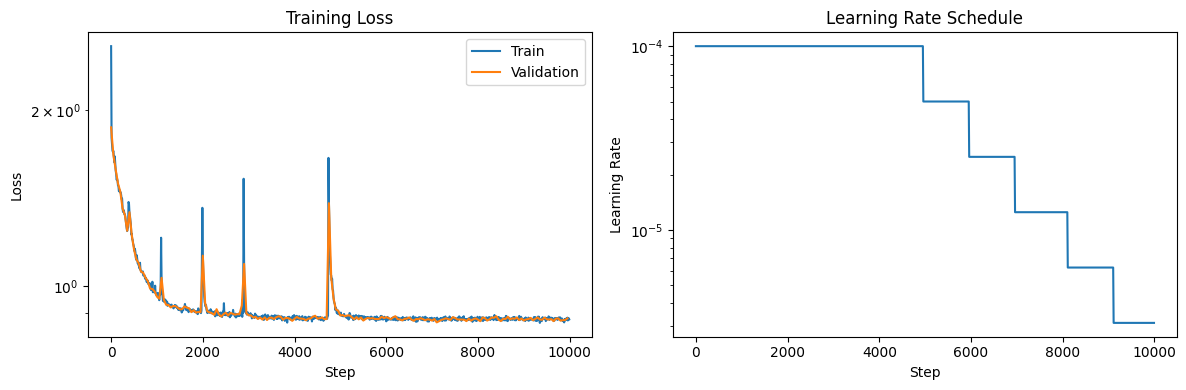


📊 Training Progress Dashboard:


INFO:training.monitor:Saved training plot to output/photonsim_siren_training/training_dashboard.png


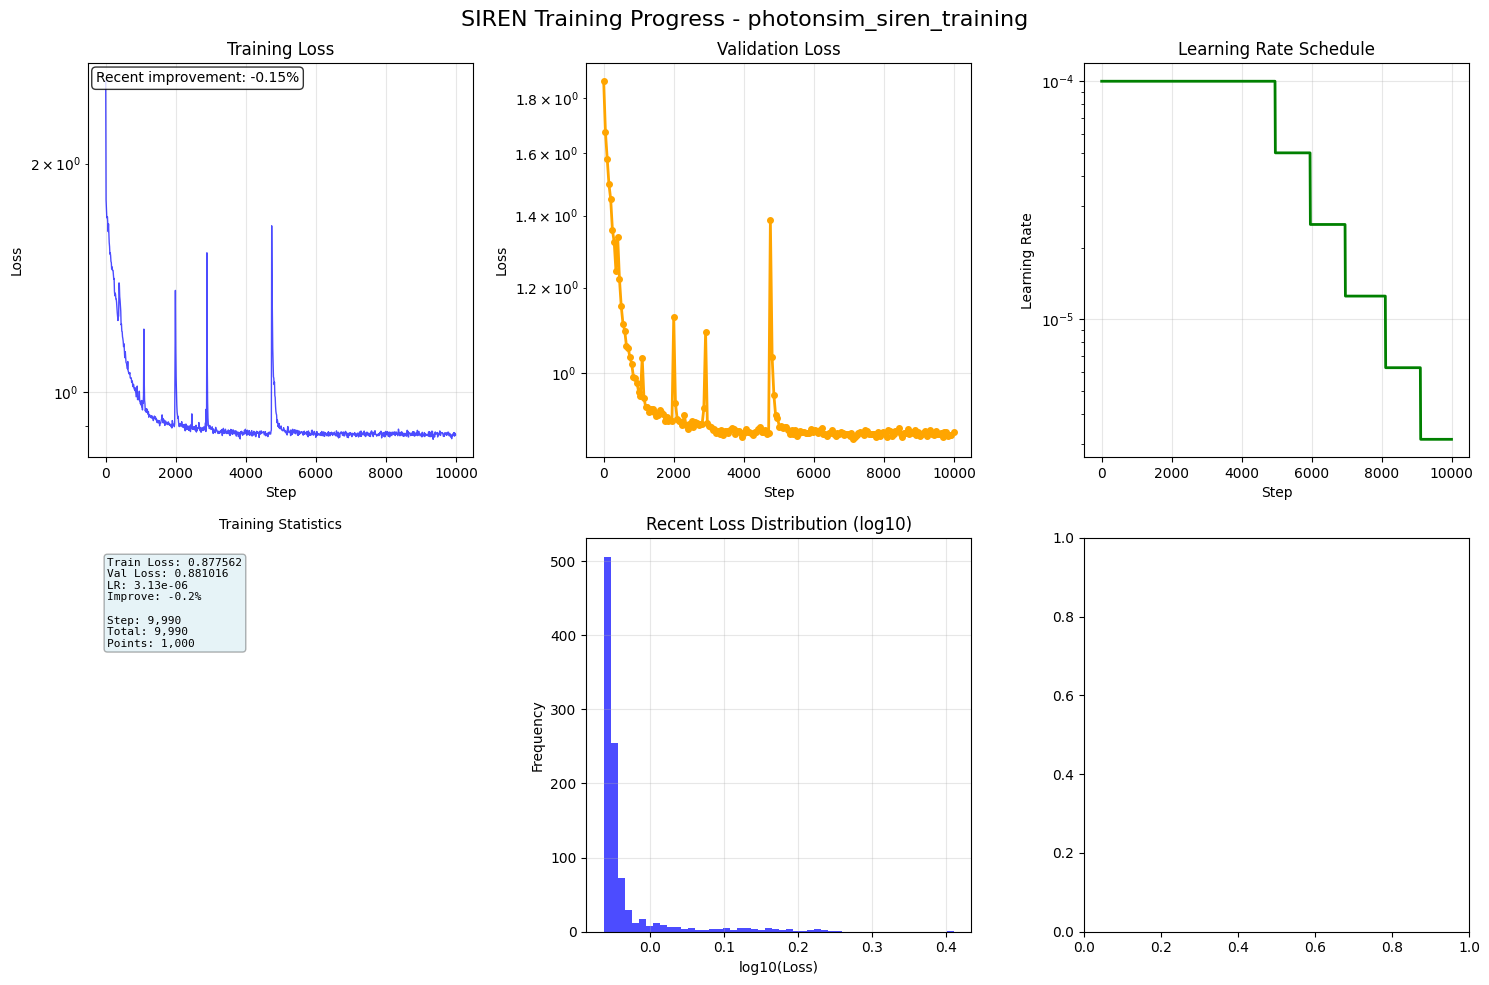

In [13]:
# Plot training history
fig = trainer.plot_training_history(save_path=output_dir / 'final_training_progress.png')
plt.show()

# Also plot monitoring dashboard
print("\n📊 Training Progress Dashboard:")
monitor_fig = monitor.plot_progress(save_path=output_dir / 'training_dashboard.png')
plt.show()

INFO:training.trainer:Saved training plot to output/photonsim_siren_training/final_training_progress.png


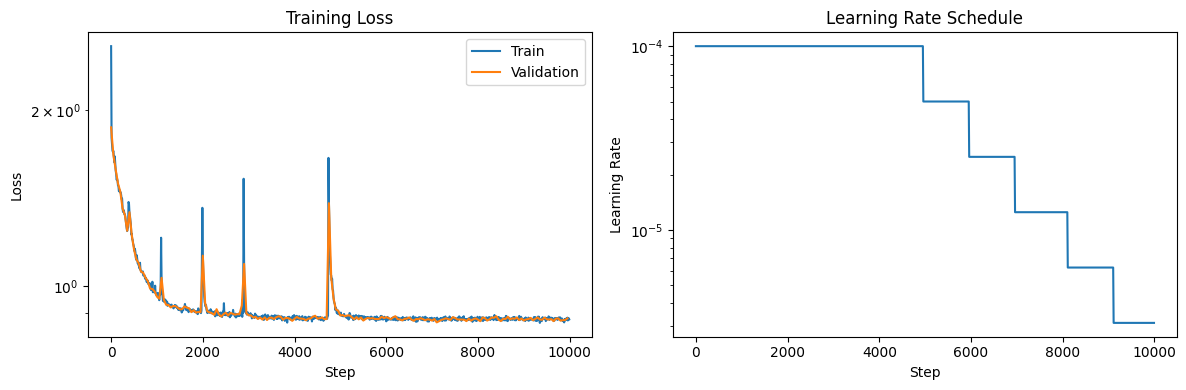

In [14]:
# Plot training history
fig = trainer.plot_training_history(save_path=output_dir / 'final_training_progress.png')
plt.show()

## 7. Analyze Model Performance

Use the analyzer to evaluate model performance.

In [15]:
# Initialize analyzer
analyzer = TrainingAnalyzer(trainer, dataset)

# Evaluate model
evaluation_results = analyzer.evaluate_model(n_samples=50000, splits=['train', 'val'])

print("\nEvaluation Results:")
for split, results in evaluation_results.items():
    metrics = results['metrics']
    print(f"\n{split.upper()} Split:")
    print(f"  R²: {metrics['r2']:.6f}")
    print(f"  RMSE: {metrics['rmse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Relative Error: {metrics['relative_error']:.6f}")
    print(f"  Correlation: {metrics['correlation']:.6f}")

INFO:training.analyzer:Evaluating model on 50000 samples...
INFO:training.analyzer:Evaluating on train split...
INFO:training.analyzer:train metrics: R² = -0.0775, RMSE = 0.941524
INFO:training.analyzer:Evaluating on val split...
INFO:training.analyzer:val metrics: R² = -0.0730, RMSE = 0.937948



Evaluation Results:

TRAIN Split:
  R²: -0.077477
  RMSE: 0.941524
  MAE: 0.731304
  Relative Error: 0.974312
  Correlation: 0.790225

VAL Split:
  R²: -0.072993
  RMSE: 0.937948
  MAE: 0.728587
  Relative Error: 1.118619
  Correlation: 0.791210


In [16]:
# Analyze error patterns
error_analysis = analyzer.analyze_error_patterns(split='val', n_samples=20000)

print("\nError Analysis:")
for analysis_name, analysis_data in error_analysis.items():
    if 'dimension_name' in analysis_data:
        dim_name = analysis_data['dimension_name']
        dim_range = analysis_data['dimension_range']
        avg_error = np.mean(analysis_data['mean_errors'])
        print(f"  {dim_name}: range {dim_range[0]:.2f}-{dim_range[1]:.2f}, avg error: {avg_error:.6f}")

INFO:training.analyzer:Analyzing error patterns on val split...



Error Analysis:
  Energy (MeV): range 100.00-1000.00, avg error: 0.778858
  Angle (degrees): range 0.18-179.82, avg error: 0.752208
  Distance (mm): range 10.00-5630.00, avg error: 0.909504
  Target Value: range -2.60-2.94, avg error: 0.954682


INFO:training.analyzer:Saved slice comparison plot to output/photonsim_siren_training/lookup_table_slices.png


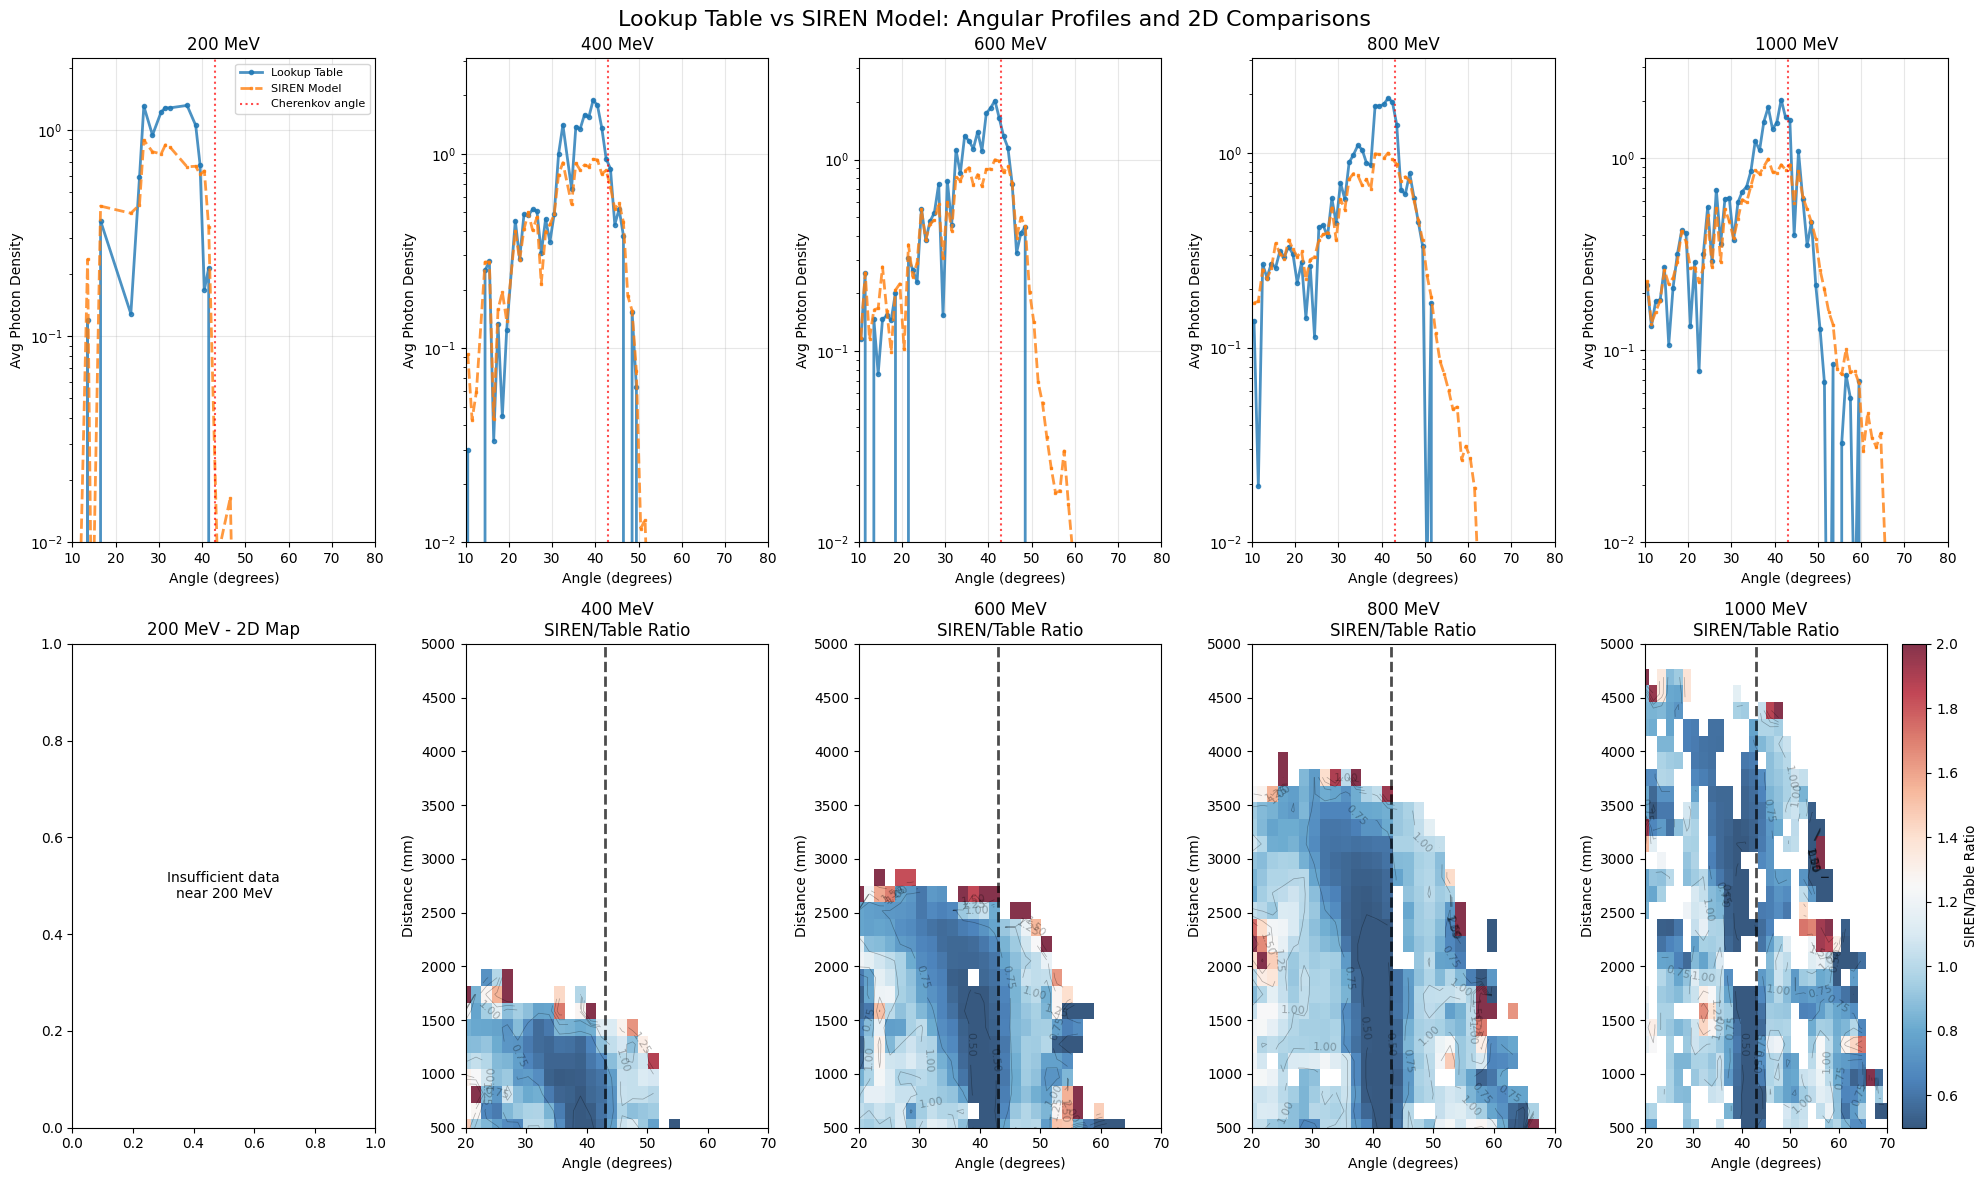

In [17]:
# Create slice comparison plots
fig_slices = analyzer.plot_lookup_table_slices(save_path=output_dir / 'lookup_table_slices.png')
plt.show()

## 8. Lookup Table Slice Comparisons

Create slice visualizations comparing lookup table expectations vs SIREN model predictions.

## 9. Test Model Predictions

Test the model on specific energy/angle/distance combinations.

In [18]:
# Export analysis results
analyzer.export_results(output_dir / 'analysis_results.json')

# Export monitoring data
monitor.export_data(output_dir / 'monitoring_data.json')

print("✓ Results exported to:")
print(f"  Model checkpoint: {output_dir / 'final_model.npz'}")
print(f"  Training config: {output_dir / 'config.json'}")
print(f"  Training history: {output_dir / 'training_history.json'}")
print(f"  Analysis results: {output_dir / 'analysis_results.json'}")
print(f"  Monitoring data: {output_dir / 'monitoring_data.json'}")
print(f"  Plots: {output_dir / '*.png'}")

INFO:training.analyzer:Exported analysis results to output/photonsim_siren_training/analysis_results.json
INFO:training.monitor:Exported training data to output/photonsim_siren_training/monitoring_data.json


✓ Results exported to:
  Model checkpoint: output/photonsim_siren_training/final_model.npz
  Training config: output/photonsim_siren_training/config.json
  Training history: output/photonsim_siren_training/training_history.json
  Analysis results: output/photonsim_siren_training/analysis_results.json
  Monitoring data: output/photonsim_siren_training/monitoring_data.json
  Plots: output/photonsim_siren_training/*.png


In [19]:
# Get final summary
summary = monitor.get_summary()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\nModel Architecture:")
print(f"  Hidden features: {config.hidden_features}")
print(f"  Hidden layers: {config.hidden_layers}")
print(f"  SIREN frequency (w0): {config.w0}")

print(f"\nTraining Configuration:")
print(f"  Learning rate: {config.learning_rate:.2e}")
print(f"  Batch size: {config.batch_size:,}")
print(f"  Total steps: {config.num_steps:,}")
print(f"  Weight decay: {config.weight_decay:.2e}")

print(f"\nDataset Information:")
print(f"  Total samples: {len(dataset.data['inputs']):,}")
print(f"  Training samples: {len(dataset.train_indices):,}")
print(f"  Validation samples: {len(dataset.val_indices):,}")
print(f"  Energy range: {dataset.energy_range[0]:.0f}-{dataset.energy_range[1]:.0f} MeV")

print(f"\nFinal Performance:")
if 'val' in evaluation_results:
    val_metrics = evaluation_results['val']['metrics']
    print(f"  Validation R²: {val_metrics['r2']:.6f}")
    print(f"  Validation RMSE: {val_metrics['rmse']:.6f}")
    print(f"  Validation MAE: {val_metrics['mae']:.6f}")
    print(f"  Relative Error: {val_metrics['relative_error']:.6f}")
    
print(f"\nOutput Directory: {output_dir}")
print("\n✓ Training completed successfully!")


TRAINING SUMMARY

Model Architecture:
  Hidden features: 256
  Hidden layers: 3
  SIREN frequency (w0): 30.0

Training Configuration:
  Learning rate: 1.00e-04
  Batch size: 65,536
  Total steps: 10,000
  Weight decay: 0.00e+00

Dataset Information:
  Total samples: 5,659,770
  Training samples: 5,093,793
  Validation samples: 565,977
  Energy range: 100-1000 MeV

Final Performance:
  Validation R²: -0.072993
  Validation RMSE: 0.937948
  Validation MAE: 0.728587
  Relative Error: 1.118619

Output Directory: output/photonsim_siren_training

✓ Training completed successfully!
